In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [70]:
'''
Implementing the iterative pagerank algorithm
'''

# distribution_vecor E is the pr distribution of ranks of web pages that users jump to when they get bored after successive links at ranodm
def build_transition_matrix(G, distribution_vector=None):
    """
    Absorbing pages: (dead) Pages which have an incoming link, but no outgoing link (AKA Dangling links). 
    In this case, we assume that if random surfer happens to land at such a page(node), they can teleport to any of the nodes with equal probability. This helps the algorithm to converge

    """
    num_pages = len(G.nodes())
    transition_matrix = np.zeros(shape=(num_pages, num_pages))

    # building standard distribution_vector E if none provided 
    if distribution_vector is None:
        # all entries of random_surf = 1/T
        distribution_vector = np.ones(shape = (num_pages, )) /num_pages

    # distribution_vector is provided by not appropraite
    elif len(distribution_vector) != num_pages:
        print(f"Distribution Vector has incorrect dimensions!\nShape of distribution_vector = {distribution_vector.shape}\nShape of Transition Matrix = {transition_matrix.shape}")
        exit()

    # building adjacent matrix from graph
    # '1' and '0' represent the presence or absence of a link between any two pages
    adj_matrix = np.zeros(shape=(num_pages, num_pages))
    for link in G.edges():
        adj_matrix[link[0]-1, link[1]-1] = 1 # -1 since nodes index starts from 1
    # print(adj_matrix)

    # building transition matrix
    # entries value: 1/T
    
    # Calculate the sum of outgoing edges for each node
    out_degree = np.sum(adj_matrix, axis=1)
    # Avoid division by zero using NumPy broadcasting
    # Divide only where out_degree is not zero, otherwise keep the value as zero
    transition_matrix = np.where(out_degree[:, np.newaxis] != 0, adj_matrix / out_degree[:, np.newaxis], 0)
    # print(transition_matrix)
    
    # building stochastic transition matrix for absorbing pages, ie nodes with col that are all 0
    distribution_matrix = np.zeros(shape=(num_pages, num_pages)) 
    for page in G.nodes():
        # Check for any dead nodes
        if len(G.out_edges(page))==0:
            distribution_matrix[:, page-1] = distribution_vector # -1 since nodes index starts from 1
    # print(distribution_matrix)
    
    # stochastic matrix
    stochastic_matrix = transition_matrix + distribution_matrix
    # print(stochastic_matrix)
    
    return np.transpose(stochastic_matrix), distribution_vector


def pagerank(G, teleport_pr=0.2, initial_pagerank=None, distribution_vector=None, max_iterations=100, tolerance=1.0e-6):
    """
    Teleportation probability: Probability that a random surfer no longer wants to keep following hyperlinks, but restarts the search process. 
    """
    num_pages = len(G.nodes())

    # Initializing initial pagerank, R0
    if initial_pagerank is None:
        initial_pagerank = np.ones(num_pages) / num_pages
    elif len(initial_pagerank) != num_pages:
        print(f"Initial Pagerank Vector has incorrect dimensions!\nShape of initial_pagerank = {initial_pagerank.shape}\nShape of Transition Matrix = ({num_pages}, {num_pages})")
        exit()
    pagerank = initial_pagerank

    # Building transition probability matrix M
    pagerank_matrix, distribution_vector = build_transition_matrix(G, distribution_vector)
    # print(pagerank_matrix)

    # Keep track of L1 norm between pageranks of successive iterations
    norm_history = []
    #Keep track of pagerank histories
    pagerank_history = []
    pagerank_history.append(pagerank)
    
    # Iterate until convergence
    for i in range(max_iterations):
        # Formula
        new_pagerank = (1 - teleport_pr) * np.dot(pagerank_matrix, pagerank) + teleport_pr * distribution_vector

        # accumulate norm
        norm = np.linalg.norm(new_pagerank - pagerank, 1)
        norm_history.append(norm)

        # check for convergence
        if norm < tolerance:
            break

        pagerank = new_pagerank
        pagerank_history.append(pagerank)
    
    closed_form_pagerank = calc_closed_form(pagerank_matrix, teleport_pr, distribution_vector)
    print_statistics(G, teleport_pr, initial_pagerank, distribution_vector, max_iterations, tolerance, pagerank_matrix, pagerank, closed_form_pagerank, i, norm_history, pagerank_history)
    return pagerank

'''
Obtain the closed form solution to valifate that the page rank algorithm converges numerically, using
R = (I - c1M)^-1 b
'''
def calc_closed_form(M, teleport_pr, distribution_vector):
    n = len(M)

    # Identity Matrix
    I = np.eye(n)

    # Construct b vector
    b = teleport_pr * distribution_vector

    # Calculate (I - (1 - teleportation_probability) * M)^-1
    R_inv = np.linalg.inv(I - (1 - teleport_pr) * M)

    # Calculate R = (I - (1 - teleportation_probability) * M)^-1 * b
    R = np.dot(R_inv, b)

    return R


def print_statistics(G, teleport_pr, initial_pagerank, distribution_vector, max_iterations, tolerance, pagerank_matrix, final_pagerank, closed_form_pagerank, iteration, norm_history, pagerank_history):
    # Print example definitions
    print(f"\nProblem definition..")
    print("Number of pages: ", len(G.nodes()))
    print("Number of links: ", len(G.edges()))
    print(f"\nInitial Pagerank: ", initial_pagerank)
    print("Distribution Vector: ", distribution_vector)
    print("Teleportation Probability: ", teleport_pr)
    print(f"\ti.e. alpha: ", 1-teleport_pr)
    # print(f"\nmax_iterations: ", max_iterations)
    # print(f"tolerance: ", tolerance)

    # Print intermediate results
    print(f"\nPagerank Matrix..\n" , pagerank_matrix)

    # Print Results
    print(f"\n=======================Results=======================")
    print("Sanity Check: ", sanity_check(final_pagerank, closed_form_pagerank))
    print(f"\nClosed form solution (to validate with)..")
    print(closed_form_pagerank)
    print(f"\nPower Iteration PageRank..")
    print(final_pagerank)
    print(f"\nConverged at {iteration+1} iterations..")
    for i in range(iteration):
        print(f"iteration {i}: ", pagerank_history[iteration])
    # Display Convergence Plot
    plt.figure(figsize=(5,4))
    plt.plot(range(iteration+1), norm_history)
    plt.xlabel('iterations')
    plt.ylabel('Euclidean Norm')
    plt.title('Convergence plot')
    plt.show()

def sanity_check(iteration, closed_form):
    if np.allclose(iteration, closed_form,rtol=1e-03,atol=1e-03):
        #print("Power iteration and closed form yielded the same page rank")
        return "Correct"
    else:
        #print("Power iteration and closed form are incorrect")
        return "Incorrect"


# Experiments

## Four-webpages on Slide 53 of Lecture 7

### Standard inputs

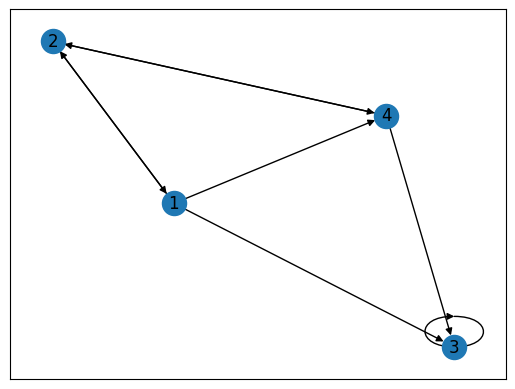

In [64]:
# 4 web-pages example in Lecture slides 53
g1 = nx.DiGraph()
g1.add_edges_from([(1,2), (1,3), (1,4),
                   (2,1), (2,4),
                   (3,3),
                   (4,2), (4,3)])
nx.draw_networkx(g1)


Problem definition..
Number of pages:  4
Number of links:  8

Initial Pagerank:  [0.25 0.25 0.25 0.25]
Distribution Vector:  [0.25 0.25 0.25 0.25]
Teleportation Probability:  0.2
	i.e. alpha:  0.8

Pagerank Matrix..
 [[0.         0.5        0.         0.        ]
 [0.33333333 0.         0.         0.5       ]
 [0.33333333 0.         1.         0.5       ]
 [0.33333333 0.5        0.         0.        ]]

=======================Results=======================
Sanity Check:  Correct

Closed form solution (to validate with)..
[0.10135135 0.12837838 0.64189189 0.12837838]

Power Iteration PageRank..
[0.10135159 0.12837872 0.64189097 0.12837872]

Converged at 25 iterations..
iteration 0:  [0.10135159 0.12837872 0.64189097 0.12837872]
iteration 1:  [0.10135159 0.12837872 0.64189097 0.12837872]
iteration 2:  [0.10135159 0.12837872 0.64189097 0.12837872]
iteration 3:  [0.10135159 0.12837872 0.64189097 0.12837872]
iteration 4:  [0.10135159 0.12837872 0.64189097 0.12837872]
iteration 5:  [0.10135

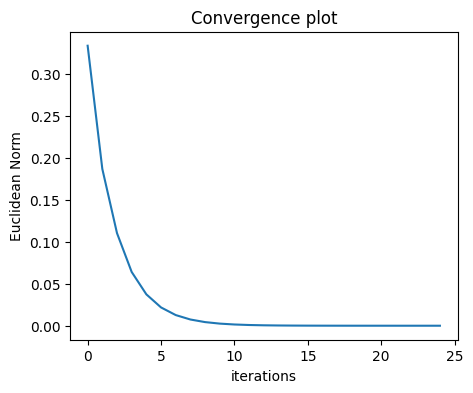

array([0.10135159, 0.12837872, 0.64189097, 0.12837872])

In [71]:
pagerank(g1, teleport_pr=0.2)